In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_scala(filename, tag_offset = None):
    if tag_offset is None:
        where = slice(None)
    else:
        where = slice(tag_offset, None)
    with File(filename, 'r') as f:
        try:
            for tag, iom, img, dt in zip(
                f['/bunches'][where],
                f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'][where],
                f['/vmi/andor'],
                f['/user_laser/delay_line/position'][where],
            ):
                yield {
                    'tag': tag,
                    'iom_intensity_pc': iom,
                    'img_intensity': img.sum(),
                    'delay': round(dt, 2),
                }
        except KeyError:
            return


def read_img(filename, tag_offset = None):
    if tag_offset is None:
        where = slice(None)
    else:
        where = slice(tag_offset, None)
    with File(filename, 'r') as f:
        try:
            for tag, img in zip(
                f['/bunches'][where],
                f['/vmi/andor'],
            ):
                yield {
                    'tag': tag,
                    'img': img.astype('double'),
                }
        except KeyError:
            return

In [3]:
run = 169
tag_offset = 0  # 0 or 1
filenames = sorted(fn for fn in set(iglob(f"/data/*/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))

with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala, tag_offset=tag_offset)
        .flatten()
        .to_dataframe()
        .compute()
    )
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 26.7s


,delay,img_intensity,iom_intensity_pc,tag
0,-6.75,87534716,92.173576,483503863
1,-6.75,90646702,123.567009,483503864
2,-6.75,89428964,114.913559,483503865
3,-6.75,88148069,100.866508,483503866
4,-6.75,92594470,130.129623,483503867
5,-6.75,87779284,101.575470,483503868
6,-6.75,89682436,113.869858,483503869
7,-6.75,89501971,117.642975,483503870
8,-6.75,91925031,132.814407,483503871
9,-6.75,87612190,93.507385,483503872


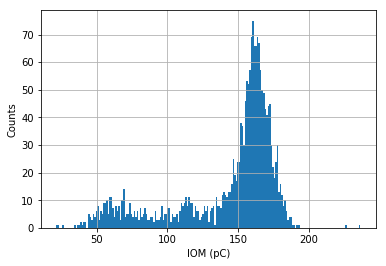

In [4]:
plt.hist(df["iom_intensity_pc"], bins=200)
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

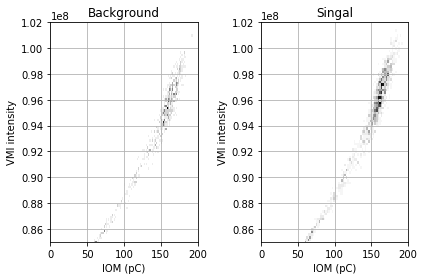

In [5]:
bg_period, bg_mod = 3, 0  # /Background_Period
df["is_bg"] = df["tag"] % bg_period == bg_mod
plt.figure()
plt.subplot(121)
where = df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Background")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(0, 200)
plt.ylim(0.85e8, 1.02e8)
plt.grid(True)

plt.subplot(122)
where = ~df["is_bg"]
plt.hist2d(df[where]["iom_intensity_pc"],
           df[where]["img_intensity"], bins=[100, 100], cmap="Greys")
plt.title("Singal")
plt.xlabel("IOM (pC)")
plt.ylabel("VMI intensity")
plt.xlim(0, 200)
plt.ylim(0.85e8, 1.02e8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
ddf = (
    from_sequence(filenames)
    .map(read_img, tag_offset=tag_offset)
    .flatten()
    .to_dataframe()
    .merge(df, on="tag")
)
where = (
    50 < ddf['iom_intensity_pc']  # Change me!
)

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg, 'delay': dt,
                'count': delayed(ddf[where & (ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['img'].to_bag().count()),
                'summed': delayed(ddf[where & (ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['img'].to_bag().sum()),
            }
            for bg in [True, False] for dt in df["delay"].unique()
        ],
    )

summed = pd.DataFrame(list(summed)).set_index(['delay', 'is_bg'])
summed

[########################################] | 100% Completed | 25.5s


count                                             summed
delay is_bg                                                          
-6.75 True     654  [[66598.0, 65212.0, 66195.0, 66446.0, 66658.0,...
      False   1310  [[133238.0, 130356.0, 132669.0, 133038.0, 1334...

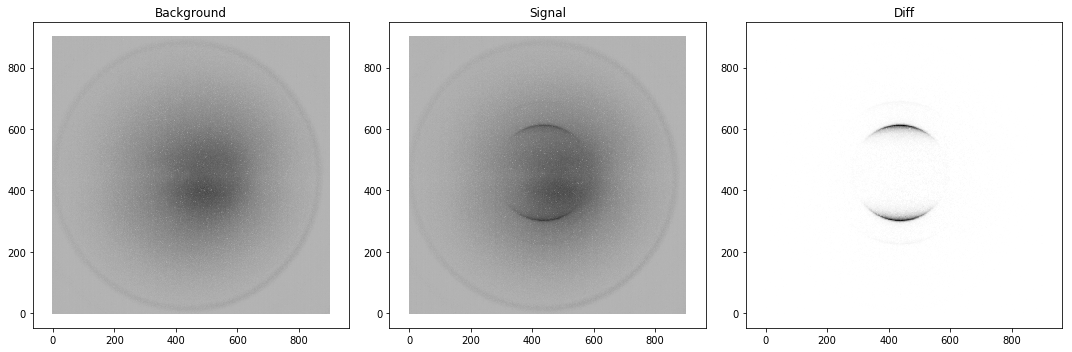

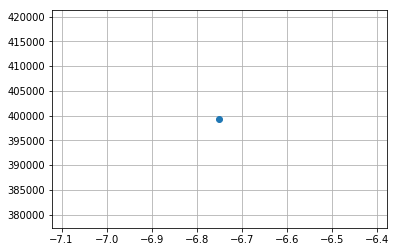

In [7]:
avg = {
    k: {'bg_n': summed.loc[(k, True), 'count'],
        'bg_img': summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'],
        'sg_n': summed.loc[(k, False), 'count'],
        'sg_img': summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count'],
        'df_n': summed.loc[(k, False), 'count'],
        'df_img': (summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count']
                   - summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'])}
    for k in df["delay"].unique()
} 

for k, d in avg.items():
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title("Background")
    plt.pcolormesh(d['bg_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(132)
    plt.title("Signal")
    plt.pcolormesh(d['sg_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.subplot(133)
    plt.title("Diff")
    plt.pcolormesh(d['df_img'], cmap="Greys")
    plt.clim(0, None)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

plt.figure()
plt.plot([k for k in avg], [d['df_img'].sum() for d in avg.values()], 'o-')
plt.grid(True)
plt.show()

In [9]:
writein = f"/data/WavelenghtScan/Run_{run:03d}/work"

for k, d in avg.items():
    with File(f"{writein}/reduced_dt={k}.h5", "w") as f:
        f['bg_n'] = d['bg_n']
        f['bg_img'] = d['bg_img']
        f['sg_n'] = d['sg_n']
        f['sg_img'] = d['sg_img']
        f['df_n'] = d['df_n']
        f['df_img'] = d['df_img']